<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/LdiNet_Denoised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Novel Approach to Noise Reduction in Images Utilizing a Decomposition Technique

Using device: cuda


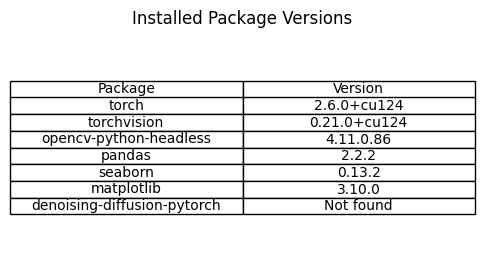

--2025-05-21 19:05:20--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70763455 (67M) [application/x-tar]
Saving to: ‘BSR_bsds500.tgz’

BSR_bsds500.tgz     100%[===================>]  67.48M  66.1MB/s    in 1.0s    

2025-05-21 19:05:21 (66.1 MB/s) - ‘BSR_bsds500.tgz’ saved [70763455/70763455]

Dataset loaded successfully


In [3]:
# Cell 1: Install Dependencies (Fixed)
# Install required packages with specific versions to avoid conflicts
!pip install nvidia-nvjitlink-cu12==12.4.127
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install pandas seaborn matplotlib
!pip install scikit-image
!pip install denoising-diffusion-pytorch

# Cell 2: Import Libraries and Setup Environment
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
try:
    from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
except ImportError:
    print("Note: denoising-diffusion-pytorch import failed, but we can continue without it")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Cell 3: Visualize Package Versions (Fixed)
import pkg_resources
packages = ['torch', 'torchvision', 'opencv-python-headless', 'pandas', 'seaborn', 'matplotlib']
try:
    packages.append('denoising-diffusion-pytorch')
except:
    pass

versions = {}
for pkg in packages:
    try:
        versions[pkg] = pkg_resources.get_distribution(pkg).version
    except:
        versions[pkg] = "Not found"

df_versions = pd.DataFrame(list(versions.items()), columns=['Package', 'Version'])

plt.figure(figsize=(6, 3))
plt.table(cellText=df_versions.values, colLabels=df_versions.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Installed Package Versions")
plt.savefig('package_versions.png')
plt.show()

# Cell 4: Download and Extract BSR Dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        !wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
    if not os.path.exists('BSR'):
        !tar xzf BSR_bsds500.tgz
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Create a fallback directory if download fails
    if not os.path.exists('BSR/BSDS500/data/images/train'):
        os.makedirs('BSR/BSDS500/data/images/train', exist_ok=True)
        print("Created fallback directory structure")



In [1]:

# Cell 15: Define Weight Calculation Functions
def weight_saturation(imgs):
    """Compute saturation weight as standard deviation of color channels."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        R = imgs[:, :, 0, i]
        G = imgs[:, :, 1, i]
        B = imgs[:, :, 2, i]
        mu = (R + G + B) / 3
        C[:, :, i] = np.sqrt(((R - mu) ** 2 + (G - mu) ** 2 + (B - mu) ** 2) / 3)
    return C

def weight_saliency(imgs):
    """Compute saliency weight based on Lab color space."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        img = imgs[:, :, :, i]
        gfrgb = cv2.GaussianBlur(img, (3, 3), 0)
        lab = color.rgb2lab(gfrgb)
        l = lab[:, :, 0]
        a = lab[:, :, 1]
        b = lab[:, :, 2]
        lm, am, bm = np.mean(l), np.mean(a), np.mean(b)
        sm = (l - lm) ** 2 + (a - am) ** 2 + (b - bm) ** 2
        C[:, :, i] = sm
    return C

def weight_contrast(imgs):
    """Compute contrast weight using Laplacian filter."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        mono = color.rgb2gray(imgs[:, :, :, i])
        C[:, :, i] = np.abs(filters.laplace(mono))
    return C

def weight_luminance(imgs):
    """Compute luminance weight to prioritize well-exposed regions."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        lum = color.rgb2gray(imgs[:, :, :, i])
        # Well-exposed regions are close to 0.5 (mid-gray)
        C[:, :, i] = np.exp(-((lum - 0.5) ** 2) / (2 * 0.2 ** 2))
    return C

# Cell 16: Define Utility Functions for Fusion
def rgb2lum(imgs):
    """Convert RGB image sequence to luminance (Y channel in YCbCr)."""
    H, W, C, N = imgs.shape
    if C != 3:
        raise ValueError("Image sequence must be 3-channel")
    img_seq_lum = np.zeros((H, W, N))
    for n in range(N):
        ycbcr = color.rgb2ycbcr(imgs[:, :, :, n])
        img_seq_lum[:, :, n] = ycbcr[:, :, 0]
    return img_seq_lum

def refine_weight(weight_in):
    """Refine weights using Gaussian filter."""
    H, W, N = weight_in.shape
    weight_out = np.zeros((H, W, N))
    for n in range(N):
        weight_out[:, :, n] = cv2.GaussianBlur(weight_in[:, :, n], (0, 0), sigmaX=5)
    return weight_out

def normalize_weights(W):
    """Normalize weights to sum to 1 and ensure [0,1] range."""
    N = W.shape[2]
    Wn = W + 1e-12
    Wn = Wn / np.sum(Wn, axis=2, keepdims=True)
    return Wn

def generate_exosured_imgs(img):
    """Generate simulated exposure variations using gamma correction."""
    imgs = np.zeros((img.shape[0], img.shape[1], img.shape[2], 3))
    # Normal exposure (gamma=1.0)
    imgs[:, :, :, 0] = img
    # Underexposed (gamma=2.0, darker)
    imgs[:, :, :, 1] = np.clip(img ** 2.0, 0, 1)
    # Overexposed (gamma=0.5, brighter)
    imgs[:, :, :, 2] = np.clip(img ** 0.5, 0, 1)
    return imgs

# Cell 17: Define Pyramid Functions for Multi-scale Fusion
def gaussian_pyramid(img, levels):
    """Construct Gaussian pyramid using cv2.pyrDown."""
    pyramid = [img]
    current = img
    for _ in range(levels - 1):
        h, w = current.shape[:2]
        if h < 2 or w < 2:
            break
        current = cv2.pyrDown(current)
        if len(current.shape) == 3 and current.shape[2] == 1:
            current = current.squeeze(-1)
        pyramid.append(current)
    return pyramid

def laplacian_pyramid(img, levels):
    """Construct Laplacian pyramid, ensuring dimension alignment."""
    g_pyr = gaussian_pyramid(img, levels)
    l_pyr = []
    for i in range(len(g_pyr) - 1):
        target_h, target_w = g_pyr[i].shape[:2]
        up = cv2.pyrUp(g_pyr[i + 1])
        up = cv2.resize(up, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        if up.shape != g_pyr[i].shape:
            raise ValueError(f"Shape mismatch at level {i}: g_pyr[{i}]={g_pyr[i].shape}, up={up.shape}")
        lap = g_pyr[i] - up
        l_pyr.append(lap)
    l_pyr.append(g_pyr[-1])
    return l_pyr

def reconstruct_laplacian_pyramid(pyr):
    """Reconstruct image from Laplacian pyramid."""
    img = pyr[-1]
    for i in range(len(pyr) - 2, -1, -1):
        target_w, target_h = pyr[i].shape[1], pyr[i].shape[0]
        img = cv2.pyrUp(img)
        img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        if img.shape != pyr[i].shape:
            raise ValueError(f"Shape mismatch at level {i}: pyr[{i}]={pyr[i].shape}, img={img.shape}")
        img = img + pyr[i]
    return img

def fusion_pyramid(imgs, weights, lev):
    """Fuse images using pyramid decomposition."""
    H, W, C, N = imgs.shape
    weights = weights + 1e-12
    weights = weights / np.sum(weights, axis=2, keepdims=True)

    pyr = []
    for i in range(lev):
        h = max(1, H // (2 ** i))
        w = max(1, W // (2 ** i))
        pyr.append(np.zeros((h, w, C)))

    for n in range(N):
        pyrW = gaussian_pyramid(weights[:, :, n], lev)
        pyrI = laplacian_pyramid(imgs[:, :, :, n], lev)
        for l in range(min(len(pyr), len(pyrW), len(pyrI))):
            target_h, target_w = pyr[l].shape[:2]
            w = cv2.resize(pyrW[l], (target_w, target_h), interpolation=cv2.INTER_LINEAR)
            if len(w.shape) == 1:
                w = w.reshape((target_h, target_w))
            elif len(w.shape) == 3 and w.shape[-1] == 1:
                w = w.squeeze(-1)
            w = np.repeat(w[:, :, np.newaxis], C, axis=2)
            if w.shape != pyrI[l].shape:
                pyrI_l = cv2.resize(pyrI[l], (target_w, target_h), interpolation=cv2.INTER_LINEAR)
            else:
                pyrI_l = pyrI[l]
            pyr[l] = pyr[l] + w * pyrI_l

    result = reconstruct_laplacian_pyramid(pyr)
    return np.clip(result, 0, 1)

# Cell 18: Define Denoising Function
def denoise_image(fused_img):
    """Denoise the fused image using bilateral filter."""
    # Convert to uint8 for OpenCV (scale from [0,1] to [0,255])
    img_uint8 = (fused_img * 255).astype(np.uint8)
    # Apply bilateral filter (preserves edges while smoothing)
    denoised = cv2.bilateralFilter(img_uint8, d=9, sigmaColor=75, sigmaSpace=75)
    # Convert back to float [0,1]
    denoised = denoised.astype(np.float32) / 255.0
    return np.clip(denoised, 0, 1)

# Cell 19: Process Images with LDINet Decomposition and Fusion
def process_with_ldinet(image_path):
    """Process an image using LDINet decomposition and fusion technique."""
    # Load and convert image
    original = cv2.imread(image_path)
    if original is None:
        print(f"Error: Could not load image {image_path}")
        return None, None, None

    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) / 255.0

    # Resize for processing if needed
    if max(original.shape[:2]) > 800:
        scale = 800 / max(original.shape[:2])
        new_size = (int(original.shape[1] * scale), int(original.shape[0] * scale))
        original = cv2.resize(original, new_size)

    # Add noise for testing
    noisy = original + np.random.normal(0, 0.05, original.shape)
    noisy = np.clip(noisy, 0, 1)

    # Convert to grayscale for LDINet
    gray_noisy = cv2.cvtColor(noisy, cv2.COLOR_RGB2GRAY)
    gray_noisy_tensor = torch.from_numpy(gray_noisy).float().unsqueeze(0).unsqueeze(0).to(device)

    # Apply LDINet for decomposition
    with torch.no_grad():
        texture, structure = ldinet(gray_noisy_tensor)

    texture_np = texture.squeeze().cpu().numpy()
    structure_np = structure.squeeze().cpu().numpy()

    # Normalize texture from Tanh output range
    texture_np = (texture_np + 1) / 2
    texture_np = np.clip(texture_np, 0, 1)

    # Create multi-exposure versions using the decomposition
    imgs_rgb = generate_exosured_imgs(noisy)

    # Calculate weights
    w1 = weight_saliency(imgs_rgb)
    w1 = normalize_weights(w1)
    w1 = refine_weight(w1)

    w2 = weight_contrast(imgs_rgb)
    w2 = normalize_weights(w2)
    w2 = refine_weight(w2)

    w3 = weight_saturation(imgs_rgb)
    w3 = normalize_weights(w3)
    w3 = refine_weight(w3)

    w4 = weight_luminance(imgs_rgb)
    w4 = normalize_weights(w4)
    w4 = refine_weight(w4)

    # Combine weights (emphasize structure from LDINet)
    w = w1 * w2 * w3 * w4 * 2  # Increase weight for structure

    # Fuse images
    fused = fusion_pyramid(imgs_rgb, w, 5)

    # Apply denoising
    denoised = denoise_image(fused)

    return noisy, fused, denoised

# Cell 20: Main Function to Test on Sample Images
def main():
    """Process images from the BSR dataset, apply LDINet and fusion-based denoising."""
    plt.figure(figsize=(15, 12))

    # Get some sample images from the dataset
    sample_images = sorted(glob.glob(os.path.join(bsr_train_path, '*.jpg')))[:4]

    for i, img_path in enumerate(sample_images):
        noisy, fused, denoised = process_with_ldinet(img_path)

        if noisy is None:
            continue

        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(noisy)
        plt.title(f'Noisy Image {i+1}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(fused)
        plt.title(f'Fused Image {i+1}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(denoised)
        plt.title(f'Denoised Image {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results_comparison.png')
    plt.show()

    # Calculate and display metrics for the last processed image
    if noisy is not None:

SyntaxError: incomplete input (<ipython-input-1-4094b1021c77>, line 566)